## 该脚本用于从akshare实时获取投资组合收益率数据做金融理论实操研究
### 1.复刻现代金融理论中对sharpe ratio的计算。
### 2. Monte carlo模拟，用模拟结果plotefficient frontier和寻找样本中最大夏普率组合。
### 3. 应用scipy.optimize.minimize函数，直接求解最优组合演算。

In [99]:
import arrow
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## 全局参数设置，方便今后修改后能直接对性的投资组合进行测算

In [95]:
# 选股，这里选择四个股票作为初始输入，未来可以直接更改or增减list的symbols，后边的程序可以正常运行。
stocks = ["600519", "300750", "300059", "601398"]
stocks_names =["贵州茅台", "宁德时代", "东方财富", "工商银行"]
# 股票个数
stocks_num = len(stocks)
# 无风险利率，这里还没有从akshare获取数据，暂时为0，后面无风险利率函数中会重制该参数
risk_free = 0
# Monte Carlo次数
simul_num = 5000

In [104]:
def get_china_bonds_yield() -> pd.DataFrame:
    # 过去一年的中国历史债券收益率所有数据
    now = arrow.now()
    start = now.shift(years=-1)
    end = now.format('YYYYMMDD')
    start = start.format('YYYYMMDD')
    bond_china_yield_df = ak.bond_china_yield(start_date=start, end_date=end)
    return bond_china_yield_df
bond_china_yield_df = get_china_bonds_yield()
bond_china_yield_df 

                    曲线名称          日期      3月      6月      1年      3年      5年  \
0      中债中短期票据收益率曲线(AAA)  2023-08-11  2.0065  2.1973  2.3223  2.6964  2.9811   
1    中债商业银行普通债收益率曲线(AAA)  2023-08-11  1.9385  2.0704  2.2877  2.6130  2.7648   
2              中债国债收益率曲线  2023-08-11  1.5319  1.8186  1.8305  2.2573  2.4216   
3              中债国债收益率曲线  2023-08-14  1.5257  1.7972  1.8156  2.2416  2.4048   
4      中债中短期票据收益率曲线(AAA)  2023-08-14  2.0022  2.1969  2.3073  2.6890  2.9719   
..                   ...         ...     ...     ...     ...     ...     ...   
748  中债商业银行普通债收益率曲线(AAA)  2024-08-08  1.7419  1.8149  1.8598  1.9606  2.0167   
749            中债国债收益率曲线  2024-08-08  1.3875  1.4746  1.4268  1.7024  1.8349   
750    中债中短期票据收益率曲线(AAA)  2024-08-09  1.8817  1.8976  1.9190  2.0330  2.1125   
751  中债商业银行普通债收益率曲线(AAA)  2024-08-09  1.7756  1.8217  1.8876  1.9851  2.0410   
752            中债国债收益率曲线  2024-08-09  1.4067  1.4900  1.4562  1.7215  1.8706   

         7年     10年     30年  
0    3.15

In [105]:
def get_risk_free_rate(bond_china_yield_df):
    short_china_yield_df = bond_china_yield_df[bond_china_yield_df['曲线名称'] == "中债中短期票据收益率曲线(AAA)"]
    # 重制历史无风险收益率
    risk_free = short_china_yield_df.loc[:, ['3月']].mean() / 100
    return risk_free
risk_free = get_risk_free_rate(bond_china_yield_df)
risk_free

3月    0.02243
dtype: float64

## 从akshare元数据获取，获取后清洗打包，以’csv‘格式存储备用，同时返回DataFrame格式数据
本函数时间设置内设在函数内部，要修改时间，需要修改函数内部的start和end参数

In [68]:
def get_stocks_data(stocks:list) -> pd.DataFrame:
    # 构建空字典，用来存放股票数据，为做df准备
    frames = {}
    # declare 开始和截至时间，这里有arrow库
    now = arrow.now()
    start = now.shift(years=-1)
    end = now.format('YYYYMMDD')
    start = start.format('YYYYMMDD')
    # 用for循环遍历股票列表，获取akshare股票数据
    #注意，这里用的是前复权数据，保证了当前股价不变
    for code in stocks:
        bars = ak.stock_zh_a_hist(
            symbol=code,
            period='daily', 
            start_date=start, 
            end_date=end, 
            adjust="qfq")

        # 将日期列设置为bars的索引
        bars.index = pd.to_datetime(bars['日期'])
        # 将股票数据存入字典
        frames[code] = bars['收盘']

    df = pd.DataFrame(frames)
    returns = df.pct_change()
    returns.dropna(how='any', inplace=True)
    # 这里有个问题，这个格式操作不会改变元数据，如果赋值给本身的话，本身又会变成styler对象
    # styler对象不能用print打印出来
    returns.style.format('{:,.2%}')
    returns
    returns.to_csv('MPT.csv')
    return returns
stocks_returns = get_stocks_data(stocks)

In [69]:
# 源数据赋值给新的变量，避免改变源数据
stocks_returns_daily = stocks_returns.copy()

1584369420880
1584469582608


## 随机生成股票权重数组，只需要输入股票数量即可，不改变其他任何参数

In [76]:
# 获取随机权重数组，不会改变任何源数据
def get_weights(stocks_num: int) -> list:
    # 生成股票个数的随机权重
    weights = np.array(np.random.random(stocks_num))

    # print('随机权重:', weights)

    weights = weights / np.sum(weights)
   
    # print('和为1的随机权重:', weights)

    return weights
# 调用一下
# weights = get_weights(stocks_num)


# Get metrics
计算组合的returns序列， 年华收益率，年华波动率，夏普比率
一般认为，如果我们投资的是指数或者权重股，那么夏普超过1是可以接受的投资；
对其它高风险权益类投资，一般要超过1.8，但很少有资产能超过3。

In [71]:
# 方法一，直接计算annulized的组合returns, volatility, sharpe ratio.
# 还有些方法是直接用模块里的函数，比如有empyrical.sharpe_ratio函数
def get_metrics(weights: list, stocks_returns_daily: pd.DataFrame, risk_free: float=0) -> tuple:
    # 计算收益率,df.dot(weights)更直观，逐个对行进行点乘
    # 先对每天收益率加权求和，相当于把组合看作一直股票，retrurns是它每天收益率的时间序列
    port_return_daily = stocks_returns_daily.dot(weights)
    # 计算平均日收益率有两种方法
    # 一种是样本取平均值，这里用的就是这种方法，这种方法没考虑复利
    # 第二种方法是取对数log（1+return）求平均值后，再取一个相应对数的指数后-1
    # 最后统一乘以252将日平均收益率annulized
    port_annual_returns = port_return_daily.mean() * 252
    # 计算年化波动率
    port_annual_volatility = port_return_daily.std() * np.sqrt(252)
    # 计算夏普比率
    port_sharpe_ratio = (port_annual_returns - risk_free) / port_annual_volatility

    return (port_annual_returns, port_annual_volatility, port_sharpe_ratio)
    # # 计算最大回撤
    # max_drawdown = (returns['Portfolio'].cummax() - returns['Portfolio']).max()
    # # 计算索提诺比率
    # sortino_ratio = (annual_returns - 0.02) / (returns['Portfolio'].std() * np.sqrt(252))
    # # 计算信息比率
    # information_ratio = (returns['Portfolio'].mean() - returns['SPY'].mean()) / (returns['Portfolio'].std() * np.sqrt(252))
    # # 计算收益回撤比
    # return_risk_ratio = annual_returns / max_drawdown
    # # 计算收益风险比
# metrics = get_metrics(weights, stocks_returns, risk_free)
# metrics



# Monte Carlo模型
本质上就是高频模拟不同weights的结果，找出需要的最优weights的资产组合

In [75]:
def monte_carlo(stock_nums, simul_num, stocks_returns_daily, risk_free):
    # 预先做好装结果的容器
    # 装每次模拟权重的list
    weights_list = []
    # 装每次模拟port年化收益率的array
    returns_arr = np.zeros(simul_num)
    # 装每次模拟port年化波动率(std)的array
    vol_arr = np.zeros(simul_num)
    # 装每次模拟port夏普比率的array
    sharpe_arr = np.zeros(simul_num)

    for i in range(simul_num):
        weights = get_weights(stock_nums)
        metrics = get_metrics(weights, stocks_returns_daily, risk_free)

        weights_list.append(weights)

        returns_arr[i] = metrics[0]
        vol_arr[i] = metrics[1]
        sharpe_arr[i] = metrics[2]
    
    print(len(weights_list))
    print(len(returns_arr))
    print(len(vol_arr))
    print(len(sharpe_arr))
    # 再构造一个df容器，把5000模拟的四个arr放进去
    monte_carlo_df = pd.DataFrame({
        'port_returns': returns_arr,
        'port_vol': vol_arr,
        'sharpe': sharpe_arr,
        'weights': weights_list
    })

    return monte_carlo_df
 
monte_carlo_df = monte_carlo(stocks_num, simul_num, stocks_returns, risk_free)
monte_carlo_df.head()

随机权重: [0.35360288 0.28174354 0.34677855 0.10314293]
和为1的随机权重: [0.32582082 0.25960737 0.31953267 0.09503914]
随机权重: [0.94703718 0.01145081 0.92592052 0.58685479]
和为1的随机权重: [0.38321986 0.00463358 0.37467498 0.23747157]
随机权重: [0.52803388 0.88899077 0.91678846 0.15043186]
和为1的随机权重: [0.21255306 0.35785149 0.36904109 0.06055436]
随机权重: [0.06030096 0.19036587 0.67416939 0.07002827]
和为1的随机权重: [0.06061223 0.19134854 0.67764946 0.07038976]
随机权重: [0.01849329 0.36615044 0.61849977 0.87766408]
和为1的随机权重: [0.00983263 0.19467725 0.32884798 0.46664214]
随机权重: [0.93471893 0.03227784 0.76797207 0.05728423]
和为1的随机权重: [0.52153289 0.01800964 0.42849533 0.03196213]
随机权重: [0.51644131 0.21577287 0.0383027  0.22167369]
和为1的随机权重: [0.52050617 0.21747119 0.03860418 0.22341846]
随机权重: [0.29925284 0.91360214 0.90164989 0.72535443]
和为1的随机权重: [0.10537594 0.32170683 0.31749808 0.25541914]
随机权重: [0.58126239 0.04779962 0.5596778  0.06296388]
和为1的随机权重: [0.46437699 0.03818765 0.44713282 0.05030255]
随机权重: [0.34839327 0.63299727

,port_returns,port_vol,sharpe,weights
0,-0.269681,0.199686,-1.350523,"[0.32582081868502505, 0.2596073696205003, 0.31..."
1,-0.183804,0.161376,-1.138980,"[0.3832198628820431, 0.004633583975960354, 0.3..."
2,-0.308088,0.223379,-1.379216,"[0.2125530621534754, 0.35785149383688897, 0.36..."
3,-0.362233,0.234622,-1.543900,"[0.06061223450612872, 0.1913485395018383, 0.67..."
4,-0.060666,0.150441,-0.403259,"[0.009832632213329176, 0.19467724852543963, 0...."


### 在monte carlo模拟的基础上，超出夏普比例最大的组合

In [78]:
# 定位最大夏普比率
def get_max_sharpe(monte_carlo_df):
    position = monte_carlo_df['sharpe'].idxmax()
    monte_carlo_max_sharpe = monte_carlo_df.iloc[position, :]
    print(monte_carlo_max_sharpe)
    return monte_carlo_max_sharpe

monte_carlo_max_sharpe = get_max_sharpe(monte_carlo_df)

port_returns                                             0.219889
port_vol                                                 0.141079
sharpe                                                    1.55862
weights         [0.05233067351807805, 0.04733473058063166, 0.0...
Name: 2993, dtype: object


# Plotting the Monte Carlo Simulation Results
Efficient frontier
CML

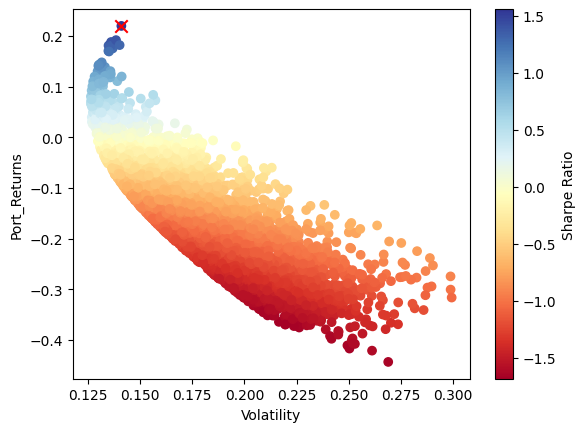

In [86]:
# 构造画图函数，将mente carlo模拟后的port收益率和波动率散点图画出
# 纵轴收益率，横轴波动率
def plot_monte_carlo_ret_vol(monte_carlo_df, monte_carlo_max_sharpe):
    # 主图，5000模拟的收益率-波动率散点图
    plt.scatter(
        monte_carlo_df['port_vol'],
        monte_carlo_df['port_returns'],
        c=monte_carlo_df['sharpe'],
        cmap='RdYlBu'
    )
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Port_Returns')
    # 特殊点，sharpe ratio最大的点
    plt.scatter(monte_carlo_max_sharpe['port_vol'], monte_carlo_max_sharpe['port_returns'], c='red', s=80, marker='x')
    plt.show()
plot_monte_carlo_ret_vol(monte_carlo_df, monte_carlo_max_sharpe)

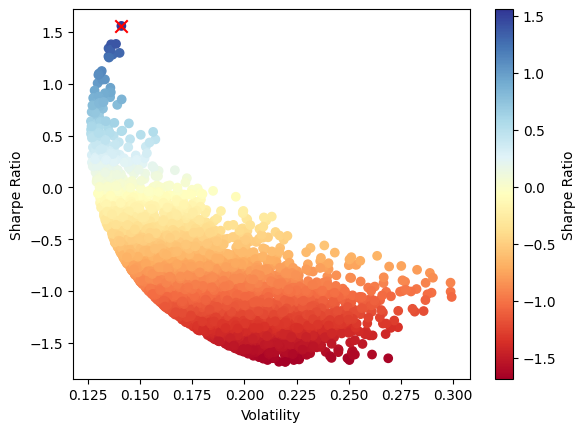

In [87]:
# 纵轴夏普比率，横轴波动率
def plot_monte_carlo_sharpe_vol(monte_carlo_df, monte_carlo_max_sharpe):
    # 主图，5000模拟的收益率-波动率散点图
    plt.scatter(
        monte_carlo_df['port_vol'],
        monte_carlo_df['sharpe'],
        c=monte_carlo_df['sharpe'],
        cmap='RdYlBu'
    )
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Sharpe Ratio')
    # 特殊点，sharpe ratio最大的点
    plt.scatter(monte_carlo_max_sharpe['port_vol'], monte_carlo_max_sharpe['sharpe'], c='red', s=80, marker='x')
    plt.show()
plot_monte_carlo_sharpe_vol(monte_carlo_df, monte_carlo_max_sharpe)

# Optimize the portfolio： scipy.optimize.minimize
以上用的monte carlo是将尽可能多的组合全部计算出来，然后找最有，是最慢的方法
以下是用scipy.optimize.minimize来优化，速度很快，但是需要先定义一个函数，这个函数就是目标函数。本质上是在约定条件下，求出函数最优解。

# 用minimize函数求最大夏普比率

In [92]:
# 预先设置参数和约束条件
# 目标fun， 负sharpe的最小，就是正sharpe的最大
def get_negative_sharpe(weights):
    return -get_metrics(weights, stocks_returns_daily, risk_free)[2]
# 初始自变量值的list
init_guess = [1/stocks_num for i in range(stocks_num)]
# 自变量的取值范围
bounds = tuple((0, 1) for stock in stocks)
# 约束条件
# 1. 每个资产的投资比例加起来等于，constraints限制的就是所有的自变量的list
# 2. eq表达式等于0，ineq表示表达式大于0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

res = minimize(fun=get_negative_sharpe, 
        x0=init_guess, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.9736096034402162
       x: [ 5.551e-17  5.551e-17  8.882e-16  1.000e+00]
     nit: 2
     jac: [ 1.569e+00  1.487e+00  2.336e+00 -4.470e-08]
    nfev: 10
    njev: 2

In [94]:
opt_metrics = get_metrics(res.x, stocks_returns_daily)
opt_metrics

(np.float64(0.327664789634615),
 np.float64(0.16602310257482514),
 np.float64(1.9736096034402162))

## 用minimize求收益最大化

In [96]:
# 预先设置参数和约束条件
# 目标fun， 负return的最小，就是正return的最大
def get_negative_port_ret(weights):
    return -get_metrics(weights, stocks_returns_daily, risk_free)[0]
# 初始自变量值的list
init_guess = [1/stocks_num for i in range(stocks_num)]
# 自变量的取值范围
bounds = tuple((0, 1) for stock in stocks)
# 约束条件
# 1. 每个资产的投资比例加起来等于，constraints限制的就是所有的自变量的list
# 2. eq表达式等于0，ineq表示表达式大于0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

res_return = minimize(fun=get_negative_port_ret, 
        x0=init_guess, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints)
res_return

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.3276647896346149
       x: [ 4.441e-16  5.829e-16  4.094e-16  1.000e+00]
     nit: 3
     jac: [ 2.271e-01  3.049e-01  4.622e-01 -3.277e-01]
    nfev: 15
    njev: 3

## 用minimize求波动率最小的组合

In [98]:
# 预先设置参数和约束条件
# 目标fun
def get_vol(weights):
    return get_metrics(weights, stocks_returns_daily, risk_free)[1]
# 初始自变量值的list
init_guess = [1/stocks_num for i in range(stocks_num)]
# 自变量的取值范围
bounds = tuple((0, 1) for stock in stocks)
# 约束条件
# 1. 每个资产的投资比例加起来等于，constraints限制的就是所有的自变量的list
# 2. eq表达式等于0，ineq表示表达式大于0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

res_vol = minimize(fun=get_vol, 
        x0=init_guess, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints)
res_vol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1261737852300628
       x: [ 2.011e-01  3.230e-02  1.665e-01  6.002e-01]
     nit: 6
     jac: [ 1.263e-01  1.265e-01  1.264e-01  1.261e-01]
    nfev: 30
    njev: 6